In [9]:
!pip install sklearn-crfsuite


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import nltk
import sklearn
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from nltk.corpus import brown
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn_crfsuite import CRF  # If using CRFSuite for implementation
from sklearn.metrics import fbeta_score, accuracy_score, classification_report

In [2]:
nltk.download('brown')
nltk.download('universal_tagset')
nltk.download('punkt')

# Load the Brown corpus with the universal tagset
brown_sents = brown.tagged_sents(tagset='universal')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Hanish\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\Hanish\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Hanish\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
vocab = set(word.lower() for sent in brown_sents for word, _ in sent)

In [4]:
def word2features(sent, i, vocab):
    word = sent[i][0]
    postag = sent[i][1]
    is_unknown = word.lower() not in vocab
    
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'is_unknown': is_unknown 
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
        })
    else:
        features['BOS'] = True  # Beginning of sentence

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
        })
    else:
        features['EOS'] = True  # End of sentence

    return features

def sent2features(sent, vocab):
    return [word2features(sent, i, vocab) for i in range(len(sent))]

def sent2labels(sent):
    return [label for _, label in sent]

def sent2tokens(sent):
    return [token for token, _ in sent]


Overall Scores:
Precision weighted: 0.974
Recall weighted: 0.974
F1 weighted: 0.974
F0.5 weighted: 0.974
F2 weighted: 0.974
Precision macro: 0.947
Recall macro: 0.916
F1 macro: 0.926
F0.5 macro: 0.937
F2 macro: 0.920

POS Tag - Precision, Recall, F1
.: Precision=1.000, Recall=1.000, F1=1.000
ADJ: Precision=0.929, Recall=0.912, F1=0.920
ADP: Precision=0.976, Recall=0.982, F1=0.979
ADV: Precision=0.945, Recall=0.931, F1=0.938
CONJ: Precision=0.994, Recall=0.997, F1=0.995
DET: Precision=0.994, Recall=0.994, F1=0.994
NOUN: Precision=0.966, Recall=0.975, F1=0.971
NUM: Precision=0.968, Recall=0.961, F1=0.964
PRON: Precision=0.992, Recall=0.987, F1=0.990
PRT: Precision=0.943, Recall=0.939, F1=0.941
VERB: Precision=0.974, Recall=0.976, F1=0.975
X: Precision=0.683, Recall=0.341, F1=0.451


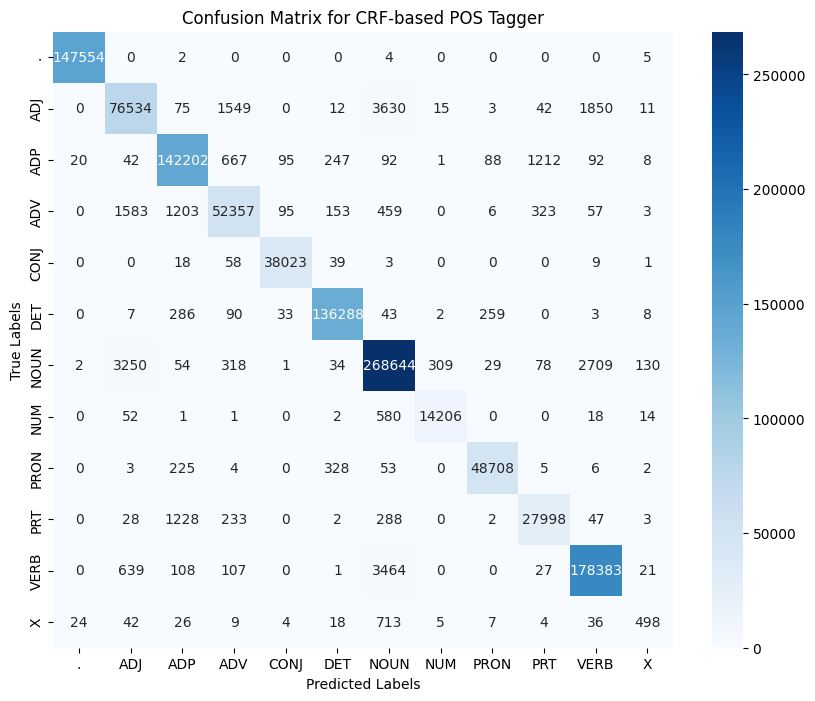

In [18]:
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from sklearn.model_selection import KFold
from sklearn_crfsuite import CRF  # Keep CRF from sklearn-crfsuite

# Assuming you have already defined sent2features and sent2labels



# Perform 5-fold cross-validation
accuracies = []
all_precision = []
all_recall = []
all_f1 = []
all_f2 = []
all_f0_5 = []
all_precision_m = []
all_recall_m = []
all_f1_m = []
all_f2_m = []
all_f0_5_m = []

all_y_test_flat = []
all_y_pred_flat = []

# A dictionary to hold results for each tag across folds
all_tags = sorted(set([label for sent in brown_sents for _, label in sent]))

# A dictionary to hold results for each tag across folds
tag_scores = {tag: {'precision': [], 'recall': [], 'f1': []} for tag in all_tags}

kf = KFold(n_splits=5)
X = [sent2features(s, vocab) for s in brown_sents]
y = [sent2labels(s) for s in brown_sents]

for train_index, test_index in kf.split(brown_sents):
    X_train, X_test = [X[i] for i in train_index], [X[i] for i in test_index]
    y_train, y_test = [y[i] for i in train_index], [y[i] for i in test_index]

    crf = CRF(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=100)
    crf.fit(X_train, y_train)

    y_pred = crf.predict(X_test)

    # Flatten the true and predicted labels
    y_test_flat = [label for sent in y_test for label in sent]
    y_pred_flat = [label for sent in y_pred for label in sent]

    all_y_test_flat.extend(y_test_flat)
    all_y_pred_flat.extend(y_pred_flat)

    # Calculate precision, recall, f1-score for each POS tag
    precision, recall, f1, support = precision_recall_fscore_support(y_test_flat, y_pred_flat, average=None, labels=sorted(set(y_test_flat)))

    for i, tag in enumerate(sorted(set(y_test_flat))):
        tag_scores[tag]['precision'].append(precision[i])
        tag_scores[tag]['recall'].append(recall[i])
        tag_scores[tag]['f1'].append(f1[i])

    overall_precision, overall_recall, overall_f1, _ = precision_recall_fscore_support(y_test_flat, y_pred_flat, average='weighted')
    f2_score = fbeta_score(y_test_flat, y_pred_flat, beta=2, average='weighted')
    f05_score = fbeta_score(y_test_flat, y_pred_flat, beta=0.5, average='weighted')
    overall_precision_m, overall_recall_m, overall_f1_m, _ = precision_recall_fscore_support(y_test_flat, y_pred_flat, average='macro')
    f2_score_m = fbeta_score(y_test_flat, y_pred_flat, beta=2, average='macro')
    f05_score_m = fbeta_score(y_test_flat, y_pred_flat, beta=0.5, average='macro')
    
    all_precision.append(overall_precision)
    all_recall.append(overall_recall)
    all_f1.append(overall_f1)
    all_f0_5.append(f05_score)
    all_f2.append(f2_score)
    all_precision_m.append(overall_precision_m)
    all_recall_m.append(overall_recall_m)
    all_f1_m.append(overall_f1_m)
    all_f0_5_m.append(f05_score_m)
    all_f2_m.append(f2_score_m)

# Calculate average precision, recall, F1 for each tag
avg_tag_scores = {}
for tag, scores in tag_scores.items():
    avg_tag_scores[tag] = {
        'precision': np.mean(scores['precision']),
        'recall': np.mean(scores['recall']),
        'f1': np.mean(scores['f1']),
    }

avg_precision = np.mean(all_precision)
avg_recall = np.mean(all_recall)
avg_f1 = np.mean(all_f1)
avg_f05 = np.mean(all_f0_5)
avg_f2 = np.mean(all_f2)
avg_precision_m = np.mean(all_precision_m)
avg_recall_m = np.mean(all_recall_m)
avg_f1_m = np.mean(all_f1_m)
avg_f05_m = np.mean(all_f0_5_m)
avg_f2_m = np.mean(all_f2_m)

print("Overall Scores:")
print(f"Precision weighted: {avg_precision:.3f}")
print(f"Recall weighted: {avg_recall:.3f}")
print(f"F1 weighted: {avg_f1:.3f}")
print(f"F0.5 weighted: {avg_f05:.3f}")
print(f"F2 weighted: {avg_f2:.3f}")
print(f"Precision macro: {avg_precision_m:.3f}")
print(f"Recall macro: {avg_recall_m:.3f}")
print(f"F1 macro: {avg_f1_m:.3f}")
print(f"F0.5 macro: {avg_f05_m:.3f}")
print(f"F2 macro: {avg_f2_m:.3f}")

print("\nPOS Tag - Precision, Recall, F1")
for tag, scores in avg_tag_scores.items():
    print(f"{tag}: Precision={scores['precision']:.3f}, Recall={scores['recall']:.3f}, F1={scores['f1']:.3f}")


labels = sorted(set(all_y_test_flat))

# Create a confusion matrix
cm = confusion_matrix(all_y_test_flat, all_y_pred_flat, labels=labels)

# Display the confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, ax=ax)
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix for CRF-based POS Tagger')
plt.show()


In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix([item for sublist in y_true for item in sublist],
                          [item for sublist in y_pred for item in sublist], labels=labels)

    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap="Blues")
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.title('Confusion Matrix')
    plt.show()

labels = list(crf.classes_)
y_true = [sent2labels(s) for s in brown_sents]
y_pred = crf.predict(X)

plot_confusion_matrix(y_true, y_pred, labels)
